In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

## Data Import

In [2]:
#import data
df = pd.read_json('3.News_With_Labels.json')
df.head()

,createdate,articles
0,2019-07-07,"{'publishdate': '2018-01-02', 'content': ' M..."
1,2019-07-07,"{'publishdate': '2018-01-02', 'content': 'If P..."
2,2019-07-07,"{'publishdate': '2018-01-02', 'content': 'A Yo..."
3,2019-07-07,"{'publishdate': '2018-01-02', 'content': ' M..."
4,2019-07-07,"{'publishdate': '2018-01-02', 'content': 'Q. ..."


In [3]:
#format data into pandas dataframe
stock_df = pd.DataFrame([])

for i in df['articles']:
    #stock_df = stock_df.append(pd.DataFrame({'publish_date': i['publishdate'], 'content': i['content'], 'label': i['label']}, index=[0]), ignore_index=True)
    stock_df = stock_df.append(pd.DataFrame({'content': i['content'], 'label': i['label']}, index=[0]), ignore_index=True)

#number of characters
print(f"Number of words in raw data: {stock_df['content'].apply(lambda x: len(x.split(' '))).sum()}") 
stock_df.head()

Number of words in raw data: 4827973


,content,label
0,\n\n\nMore on NYTimes.com\n\n\n\n\n,Hold
1,If Procter & Gamble were sponsoring a 2018 adv...,Hold
2,A YouTube star with millions of followers apol...,Hold
3,\n\n\nMore on NYTimes.com\n\n\n\n\n,Hold
4,Q. I see posts in my Twitter feed that have “...,Hold


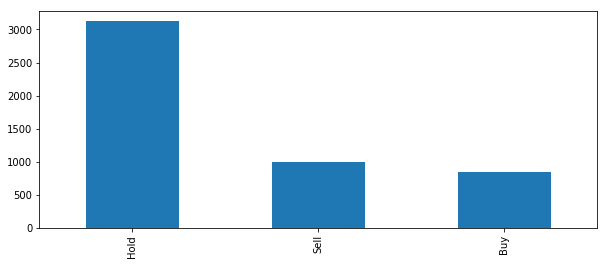

In [4]:
#let's take a look at the label spread
plt.figure(figsize=(10,4))
stock_df.label.value_counts().plot(kind='bar');

Spread looks good!

## Text Pre-Processing:
Remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [5]:
import nltk
nltk.download('stopwords')

#clean up the text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

#function to clean the text
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
#apply function to each row in the dataframe
stock_df['content'] = stock_df['content'].apply(clean_text)
#number of words after clean up
print(f"Number of words AFTER clean up: {stock_df['content'].apply(lambda x: len(x.split(' '))).sum()}") 
stock_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashcr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Number of words AFTER clean up: 2906051


,content,label
0,nytimescom,Hold
1,procter gamble sponsoring 2018 advertisement a...,Hold
2,youtube star millions followers apologized mon...,Hold
3,nytimescom,Hold
4,q see posts twitter feed sensitive content lab...,Hold


We were able to cut down the amount of words/characters significantly! (From 5 million to 3 million)

In [6]:
#Notice some of the rows have little to no content
#delete these rows to avoid error in the model

#keep a count of how many you delete
bad_rows = []
for i in range(0,stock_df.shape[0]):
    #if the number of characters is below 100
    if len(stock_df['content'].iloc[i])<100:
        bad_rows.append(i)

In [7]:
# #drop the rows we found to have fewer than 100 characters
stock_df = stock_df.drop(bad_rows)
#reset index
stock_df = stock_df.reset_index(drop=True)
print(stock_df.shape)
print(stock_df.head())

(4848, 2)
                                             content label
0  procter gamble sponsoring 2018 advertisement a...  Hold
1  youtube star millions followers apologized mon...  Hold
2  q see posts twitter feed sensitive content lab...  Hold
3  golden age television programming heading gris...  Hold
4  please take seatsit time year annual closing d...  Hold


# Text Classification Models

In [91]:
#Split the data set
X = stock_df.content
y = stock_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### NAIVE BAYES CLASSIFICATION

In [92]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

#convert to a matrix of token counts (CountVectorizer)
#then transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6309278350515464
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00       162
        Hold       0.63      1.00      0.77       612
        Sell       0.00      0.00      0.00       196

   micro avg       0.63      0.63      0.63       970
   macro avg       0.21      0.33      0.26       970
weighted avg       0.40      0.63      0.49       970



C:\Users\ashcr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SUPPORT VECTOR MACHINES (REGARDED AS ONE OF THE BEST TEXT CLASSIFIERS)

In [100]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6329896907216495
              precision    recall  f1-score   support

         Buy       0.00      0.00      0.00       162
        Hold       0.63      1.00      0.78       612
        Sell       0.50      0.01      0.02       196

   micro avg       0.63      0.63      0.63       970
   macro avg       0.38      0.34      0.27       970
weighted avg       0.50      0.63      0.49       970



### LOGISTIC REGRESSION

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\Users\ashcr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ashcr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5783505154639176
              precision    recall  f1-score   support

         Buy       0.18      0.10      0.13       162
        Hold       0.67      0.83      0.74       612
        Sell       0.31      0.20      0.24       196

   micro avg       0.58      0.58      0.58       970
   macro avg       0.39      0.37      0.37       970
weighted avg       0.52      0.58      0.54       970



### RANDOM FORESTS

In [14]:
from sklearn.ensemble import RandomForestClassifier

r_forests = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100)),
               ])
r_forests.fit(X_train, y_train)

y_pred = r_forests.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6309278350515464
              precision    recall  f1-score   support

         Buy       0.25      0.01      0.01       162
        Hold       0.64      1.00      0.78       612
        Sell       0.29      0.01      0.02       196

   micro avg       0.63      0.63      0.63       970
   macro avg       0.39      0.34      0.27       970
weighted avg       0.50      0.63      0.50       970



### KERAS

In [88]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(stock_df) * .8)
train_posts = stock_df['content'][:train_size]
train_tags = stock_df['label'][:train_size]

test_posts = stock_df['content'][train_size:]
test_tags = stock_df['label'][train_size:]

max_words = 2000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

# Build the model
model = Sequential()
#model.add(Dense(512, input_shape=(max_words,)))
model.add(Dense(200, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 3102 samples, validate on 776 samples
Epoch 1/10
3102/3102 [==============================] - 5s 2ms/step - loss: 0.9715 - acc: 0.6241 - val_loss: 1.2574 - val_acc: 0.3621
Epoch 2/10
3102/3102 [==============================] - 1s 410us/step - loss: 0.8016 - acc: 0.6615 - val_loss: 1.3601 - val_acc: 0.3673
Epoch 3/10
3102/3102 [==============================] - 1s 380us/step - loss: 0.6533 - acc: 0.7311 - val_loss: 1.4440 - val_acc: 0.3737
Epoch 4/10
3102/3102 [==============================] - 1s 378us/step - loss: 0.4920 - acc: 0.8169 - val_loss: 1.6907 - val_acc: 0.3724
Epoch 5/10
3102/3102 [==============================] - 1s 383us/step - loss: 0.3565 - acc: 0.8872 - val_loss: 1.6993 - val_acc: 0.3686
Epoch 6/10
3102/3102 [==============================] - 1s 427us/step - loss: 0.2395 - acc: 0.9362 - val_loss: 1.9915 - val_acc: 0.3763
Epoch 7/10
3102/3102 [==============================] - ETA: 0s - loss: 0.1658 - acc: 0.9607- ETA: 0s - loss: 0.1 - 1s 404us/step - loss: 0

In [89]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

970/970 [==============================] - 0s 164us/step
Test accuracy: 0.6453608248651642
